<h1>IMA 205. Challenge Anissa El Idrissi--Feissel</h1>
<h3> Cardiac pathology prediction</h3>

Contents :

I. Introduction

II. Import useful libraries

III. Exploring the data

IV. First simple method

V. A more complex method : introducing new features

VI. Adaboost method

<h2>I. Introduction</h2>

This notebook contains the code for the IMA205 course challenge of 2025. The challenge consists in a multiclass classification for heart pathologies. The dataset is composed of two datasets, one for the training (100 patients), with the labels and one for the prediction, the test set, without the labels (50 patients).

In addition to that, we have two .csv containing the id, the height and the weight of the patient and the label for the train set. 

Our goal is thus to predict as accuratly as possible the labels (from 0 to 4) of the pathologies of the test set. 


<h2>II. Import useful libraries</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import scipy.ndimage as ndi
import os
import re
import seaborn as sns
import torchio as tio
from skimage.segmentation import flood_fill
import traceback

# Libraries for Random Forest and model evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

C:\Users\Anissa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h2>III. Exploring the data</h2>

<h3>i) Load the data</h3>
 

In [2]:
# load train data
train_folder_path = "Train"

# Define the mapping from class labels to diagnostic classes
class_map = {
    0: "Healthy control",
    1: "Myocardial infarction",
    2: "Dilated cardiomyopathy",
    3: "Hypertrophic cardiomyopathy",
    4: "Abnormal right ventricle"
}

data_train = {}

# extract metadata from .CSV file
metadata = np.loadtxt(f"metadataTrain.csv", delimiter=",", skiprows=1)
ids = metadata[:, 0].astype(int)
heights_train = metadata[:, 2]
weights_train = metadata[:, 3]

for i, id_subject in enumerate(ids):
    # Get the image data and metadata for the current subject
    image_data_train = {} # Dictionary to hold image types for the subject
    for image_type in ['ED', 'ES']:
        for image_suffix in ['', '_seg']:
            image_path = os.path.join(train_folder_path, f"{id_subject:03}/{id_subject:03}_{image_type}{image_suffix}.nii")
            image_data_train[f"{image_type}{image_suffix}"] = nib.load(image_path).get_fdata()
    data_train[id_subject] = {"image_data": {k: v for k, v in image_data_train.items() if k in ['ED', 'ES', 'ED_seg', 'ES_seg']},
                        "height": heights_train[i], "weight": weights_train[i], 
                        "class": metadata[i-1, 1]}

In [3]:
# load test data
test_folder_path = "Test"
meta_test_path = "metadataTest.csv"

data = {}

# extract metadata from .CSV file
metadata = np.loadtxt(f"metadataTest.csv", delimiter=",", skiprows=1)
ids = metadata[:, 0].astype(int)
heights_test = metadata[:, 1]
weights_test = metadata[:, 2]

for i, id_subject in enumerate(ids):
    # Get the image data and metadata for the current subject
    image_data = {} # Dictionary to hold image types for the subject
    for image_type in ['ED', 'ES']:
        for image_suffix in ['', '_seg']:
            image_path = os.path.join(test_folder_path, f"{id_subject:03}/{id_subject:03}_{image_type}{image_suffix}.nii")
            image_data[f"{image_type}{image_suffix}"] = nib.load(image_path).get_fdata()
    data[id_subject] = {"image_data": {k: v for k, v in image_data.items() if k in ['ED', 'ES', 'ED_seg', 'ES_seg']},
                        "height": heights_test[i], "weight": weights_test[i]}

<h3>ii) Display an example</h3>

In order to understand fully our dataset we are going to display an example of what it contains.

In [260]:
def display_example(id_example):
    fig, axs = plt.subplots(1, 4)
    fig.set_size_inches(10, 10)
    print(f"\tID:{id_example:03}, height: {data_train[id_example]['height']:.1f}cm, weight: {data_train[id_example]['weight']:.1f}kg")
    for i, im_type in enumerate(['ED', 'ES', 'ED_seg', 'ES_seg']):
        axs[i].imshow(data_train[id_example]['image_data'][im_type][:,:,0], cmap='gray') # Show the first slice of the image
        axs[i].set_title(f"{im_type}")
    plt.show()

	ID:052, height: 161.0cm, weight: 85.0kg


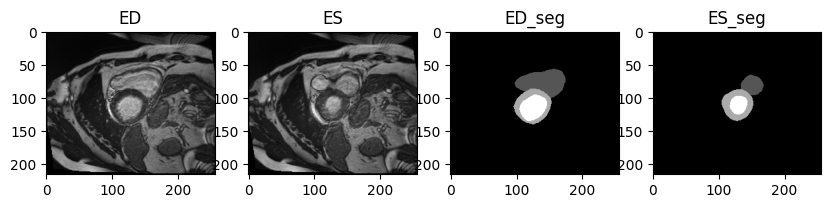

In [263]:
display_example(52)

<h3>iii) Display the proportion of the classes</h3>

In order to have the best classification possible we have to study how the different labels are distributed in our train set.

In [261]:
def display_proportion(train_labels):
    '''Print a graph of the proportion of the different classes.'''
    # Count how many samples belong to each class
    classes, counts = np.unique(train_labels, return_counts=True)
    
    plt.figure(figsize=(10, 5))  
    plt.bar(classes, counts)
    plt.xlabel('Labels')
    plt.ylabel('Number of images')
    plt.title('Proportion of each label in the train set')
    plt.show()

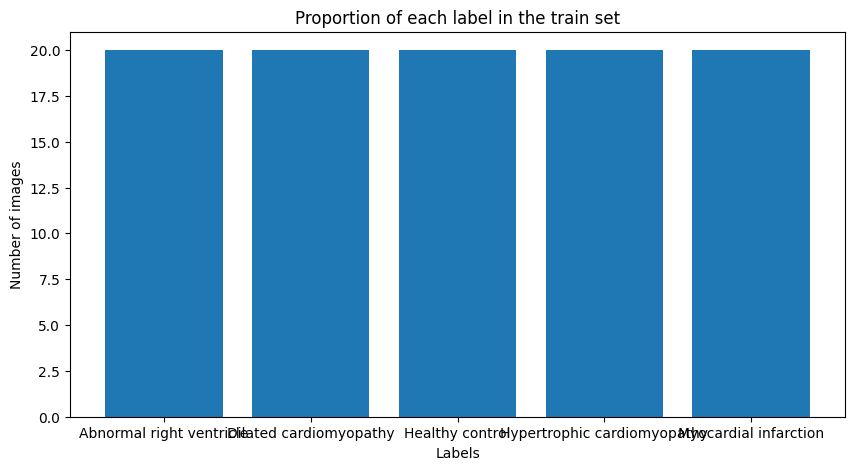

In [264]:
display_proportion([class_map[v["class"]] for v in data_train.values()])

Our training dataset is evenly distributed. It is helpful because we will not have to handle a potential bias due to imbalance representation of our classes.

<h2>IV. First simple method</h2>

In the data set, we already dispose of the height and the weight of each patient. We are thus going to try a very simple method, only using those two features and a random forest classifier.

<h3> i) Extract the height and the weight </h3>

In [6]:
def extract_features_simple(patient_id, test=False):
  if test : 
    p_id = int(patient_id)
    p_id -=101
    height = heights_test[p_id]
    weight = weights_test[p_id]
  else : 
    p_id = int(patient_id)
    p_id -=1
    height = heights_train[p_id]
    weight = weights_train[p_id]
  features = { "height" : height,
  "weight" : weight
  }
  return features

<h3> ii) Function for the creation of the features matrices for both datasets </h3>

In [5]:
def build_X_from_folder_simple(root_folder, metadata_csv=None,test=False):
    '''Returns the feature matrix, from either the test or the train dataset, and the list of the patients id.'''
    
    X = []
    patient_ids = []

    if metadata_csv is not None:
        metadata = pd.read_csv(metadata_csv)
        metadata = metadata.set_index('Id')

    # Loop through each patient folder
    for entry in sorted(os.scandir(root_folder), key=lambda e: e.name):
        patient_id = entry.name

        try:
            features = extract_features_simple(patient_id, test)
            feature_values = list(features.values())

            X.append(feature_values)
            patient_ids.append(patient_id)

        except Exception as e:
            print(f"[!] Error processing {patient_id}: {e}") # Handle any loading errors

    X = np.array(X)
    return X, patient_ids

<h3>iii) Training with Random Forest</h3>

In [7]:
meta_train_path = "metaDataTrain.csv"

X_train_simple, ids_train = build_X_from_folder_simple(train_folder_path, meta_train_path)

metadata = pd.read_csv(meta_train_path).set_index('Id')
metadata.index = metadata.index.map(lambda x: f"{int(x):03d}")
y_train_simple = metadata.loc[ids_train]['Category'].values

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train_simple, y_train_simple)

# Evaluate using 5-fold cross-validation
c = cross_val_score(clf, X_train_simple, y_train_simple, cv=5)
print(np.mean(c), np.var(c)) # Print mean and variance of cross-validation scores

0.2 0.010999999999999998


We can already see that the random forest gives a poor result. We are going to check the variability of classes, meaning how different diagnostic classes are distributed in terms of patient height and weight. 

We indeed observe that those features are not sufficient. We have to introduce new ones.

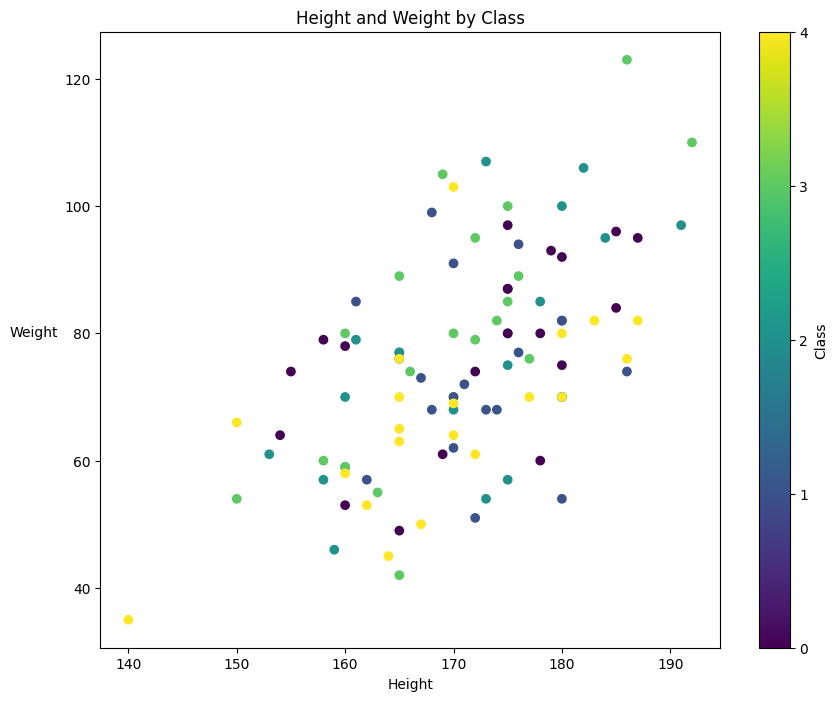

In [268]:
plt.figure(figsize=(10, 8))
plt.scatter(heights_train, weights_train, c=y_train_simple, cmap='viridis')
plt.colorbar(ticks=range(len(class_map)), label='Class')
plt.xlabel('Height')
plt.ylabel('Weight', rotation=0, ha='right')
plt.title('Height and Weight by Class')
plt.show()

In [269]:
X_test, ids_test = build_X_from_folder_simple(test_folder_path, meta_test_path,test=True)

metadata_test = pd.read_csv(meta_test_path).set_index('Id')
y_test_pred = clf.predict(X_test)

<h2>V. More complex method : introducing new features</h2>

<h3> i) Segmenting the left ventricle in the test set </h3>

The test set does not contain any segmentation for the left ventricle. This feature can provide a lot of information so we define a function capable of segmenting the left ventricle by filling the hole at the center of the myocardium. Indeed, the left ventricle is always surronded by the myocardium, it thus represents the area inside the myocardium without being the background.

In [8]:
def seg_LV(img):
    # Create a binary mask for myocardium (label 2), scaled to 255
    myoc = ((img == 2) * 255)

    # Loop through each 2D slice along the third axis (z-axis)
    for i in range(myoc.shape[2]):
        slice = myoc[:, :, i]  # Get the i-th slice of the myocardium mask

        # Use flood fill starting from top-left corner to fill the background with 255
        slice = flood_fill(slice, (0, 0), 255)

        # Now the Left Ventricle (LV) is defined as the region that was not filled (still 0)
        # Multiply by 3 to assign a new label value (e.g., LV = 3)
        LV_slice = ((slice == 0) * 3).astype(np.uint8)

        # Add the new LV label to the original image
        img[:, :, i] += LV_slice

    return img 

<h3>ii) Extract more complex features</h3>

This function extracts our new features. They are mostly based on the articles provided during the challenge. 

In [9]:
def extract_features(img_ed, img_es, voxel_volume, voxel_dims, patient_id, test=False):
    '''Return the dictionnary of all the features chosen'''
    
    # Get height and weight depending on whether this is test or training data
    if test:
        p_id = int(patient_id) - 101
        height = heights_test[p_id]
        weight = weights_test[p_id]
    else:
        p_id = int(patient_id) - 1
        height = heights_train[p_id]
        weight = weights_train[p_id]

    ## 1. Compute volumes (in mm^3)
    volume_ed = np.sum(img_ed == 3) * voxel_volume # Left ventricle volume at end-diastole 
    volume_es = np.sum(img_es == 3) * voxel_volume  # Left ventricle volume at end-systole 

    # Myocardium volume
    volume_myocardium_ed = np.sum(img_ed == 2) * voxel_volume
    volume_myocardium_es = np.sum(img_es == 2) * voxel_volume

    # Stroke Volume (SV) and Ejection Fraction (EF) for Left Ventricle
    sv = volume_ed - volume_es
    edv = volume_ed
    ef = (sv / edv) * 100 if edv != 0 else 0  # Ejection fraction (%)

    # Stroke Volume and EF for Right Ventricle
    sv = np.sum(img_es == 1) - np.sum(img_ed == 1)  # Right ventricle stroke volume
    edv = np.sum(img_ed == 1)
    efRight = (sv / edv) * 100 if edv != 0 else 0


    ## 2. Compute ratios
    volume_ratio_myocardium = volume_myocardium_es / volume_myocardium_ed if volume_myocardium_ed != 0 else 0
    sv_to_es_ratio = sv / volume_es if volume_es != 0 else 0
    myo_to_lv_ed_ratio = volume_myocardium_ed / volume_ed if volume_ed != 0 else 0
    myo_to_lv_es_ratio = volume_myocardium_es / volume_es if volume_es != 0 else 0
    myocardium_ratio_inverse = volume_myocardium_ed / volume_myocardium_es if volume_myocardium_es != 0 else 0

    # Ratio of Right to Left ventricle at ED, and myocardium to LV at ES
    ratioRightLeftED = np.sum(img_ed == 1) / np.sum(img_ed == 3)
    ratioMleftES = np.sum(img_es == 2) / np.sum(img_es == 3)


    ## 3. Indexed volumes 
    bsa = np.sqrt((height * weight) / 3600)  # Body Surface Area 

    indexedVED = (np.sum(img_ed == 3) * voxel_volume) / bsa if bsa != 0 else 0  # Indexed LV ED volume
    indexedVES = (np.sum(img_es == 3) * voxel_volume) / bsa if bsa != 0 else 0  # Indexed LV ES volume
    indexedVRED = (np.sum(img_ed == 1) * voxel_volume) / bsa if bsa != 0 else 0  # Indexed RV ED volume
    indexedVRES = (np.sum(img_es == 1) * voxel_volume) / bsa if bsa != 0 else 0  # Indexed RV ES volume

    # Heart size as total voxel volume
    heart_size = np.prod(voxel_dims)


    ## Dictionnary of all the features
    features = {
        'Volume_Myocardium_ED': volume_myocardium_ed,
        'Volume_Myocardium_ES': volume_myocardium_es,
        'height': height,
        'weight': weight,
        'indexedVED': indexedVED,
        'indexedVES': indexedVES,
        'indexedVRED': indexedVRED,
        'indexedVRES': indexedVRES,
        'heart_size': heart_size,
        'SV': sv,
        'EDV': edv,
        'EF': ef,
        'Volume_Ratio_Myocardium': volume_ratio_myocardium,
        'Heart_Size': heart_size,
        'SV_to_ES_Ratio': sv_to_es_ratio,
        'Myo_to_LV_ED_Ratio': myo_to_lv_ed_ratio,
        'Myo_to_LV_ES_Ratio': myo_to_lv_es_ratio,
        'Myocardium_Ratio_Inverse': myocardium_ratio_inverse,
        'ratioRightLeftED': ratioRightLeftED,
        'ratioMleftES': ratioMleftES,
        'efRight': efRight,
    }

    return features


<h3> iii) Function for the creation of the features matrices for both datasets </h3>

In [10]:
def build_X_from_folder(root_folder, metadata_csv=None, test=False):
    '''Returns the feature matrix, from either the test or the train dataset, and the list of the patients id.'''

    X = []  # List to store feature vectors for all patients
    patient_ids = []  # Track patient IDs

    metadata = None  
    if metadata_csv is not None:
        metadata = pd.read_csv(metadata_csv)  
        metadata = metadata.set_index('Id')  # Use patient ID as index

    # Loop over patient subfolders in alphabetical order
    for entry in sorted(os.scandir(root_folder), key=lambda e: e.name):
        patient_id = entry.name  
        patient_folder = entry.path

        try:
            files = os.listdir(patient_folder)  

            # Look for segmentation files at ED and ES timepoints
            seg_ed = next(f for f in files if re.search(r"ED.*seg", f, re.I))
            seg_es = next(f for f in files if re.search(r"ES.*seg", f, re.I))

            # Build full paths to the segmentation files
            path_ed = os.path.join(patient_folder, seg_ed)
            path_es = os.path.join(patient_folder, seg_es)

            # Load segmentation images, squeeze to remove extra dimensions
            img_ed = np.squeeze(tio.ScalarImage(path_ed))
            img_es = np.squeeze(tio.ScalarImage(path_es))

            # Extract voxel spacing and compute volume of each voxel
            voxel_dims = nib.load(path_ed).header.get_zooms()[:3]
            voxel_volume = np.prod(voxel_dims)

            # Segment the left ventricle for the test set
            if test:
                img_ed_classified, img_es_classified = seg_LV(img_ed), seg_LV(img_es)
            else:
                img_ed_classified, img_es_classified = img_ed, img_es

            # Extract features
            features = extract_features(
                img_ed_classified,
                img_es_classified,
                voxel_volume,
                voxel_dims,
                patient_id,
                test
            )

            feature_values = list(features.values())  # Convert dict to list of feature values
            feature_names = list(features.keys())

            X.append(feature_values)
            patient_ids.append(patient_id)

        except Exception as e:
            print(f"[!] Error processing patient {patient_id}: {type(e).__name__} - {e}")
            traceback.print_exc() # for debugging
            print("-" * 20)

    X = np.array(X)  
    return X, patient_ids, feature_names  # Return feature matrix and associated patient IDs


<h3>iv) Train with a random forest</h3>

In [11]:
# Build feature matrix from Training folder
X_train, ids_train, feature_names = build_X_from_folder(train_folder_path, meta_train_path, test=False)

# Load and format Metadata 
metadata_train = pd.read_csv(meta_train_path).set_index('Id')  # Read CSV and set 'Id' as index
metadata_train.index = metadata_train.index.map(lambda x: f"{int(x):03d}")  # Format IDs as 3-digit strings

# Extract labels for each patient
y_train = metadata_train.loc[ids_train]['Category'].values  # Match labels using patient IDs

# Train a Random Froest
clf = RandomForestClassifier(n_estimators=1000)  # Use 1000 trees (empiric)
clf.fit(X_train, y_train)  

# Cross-Validation to evaluate model robustness 
c = cross_val_score(clf, X_train, y_train, cv=5)  # Perform 5-fold cross-validation
print(np.mean(c), np.var(c))  # Print mean accuracy and variance across folds


0.9299999999999999 0.0005999999999999984


In [ ]:
# Function of the grid search used when needed to find the best parameters of the Random Forest
#rf = RandomForestClassifier(random_state=42)

# Define the grid of hyperparameters
#param_grid = {
    #'n_estimators': [100, 300, 500, 1000, 1500],
#}

#grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           #cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

#grid_search.fit(X_train, y_train)

# The results
#print("Best parameters:", grid_search.best_params_)
#print("Best cross-validation accuracy:", grid_search.best_score_)


<h3>v) Visualisation of the results of the training</h3>

We observe that our classifier gives very good results on the confusion matrix.
Plotting the importance of features helped me chossing which features to keep in order to classify as efficiently as I can.

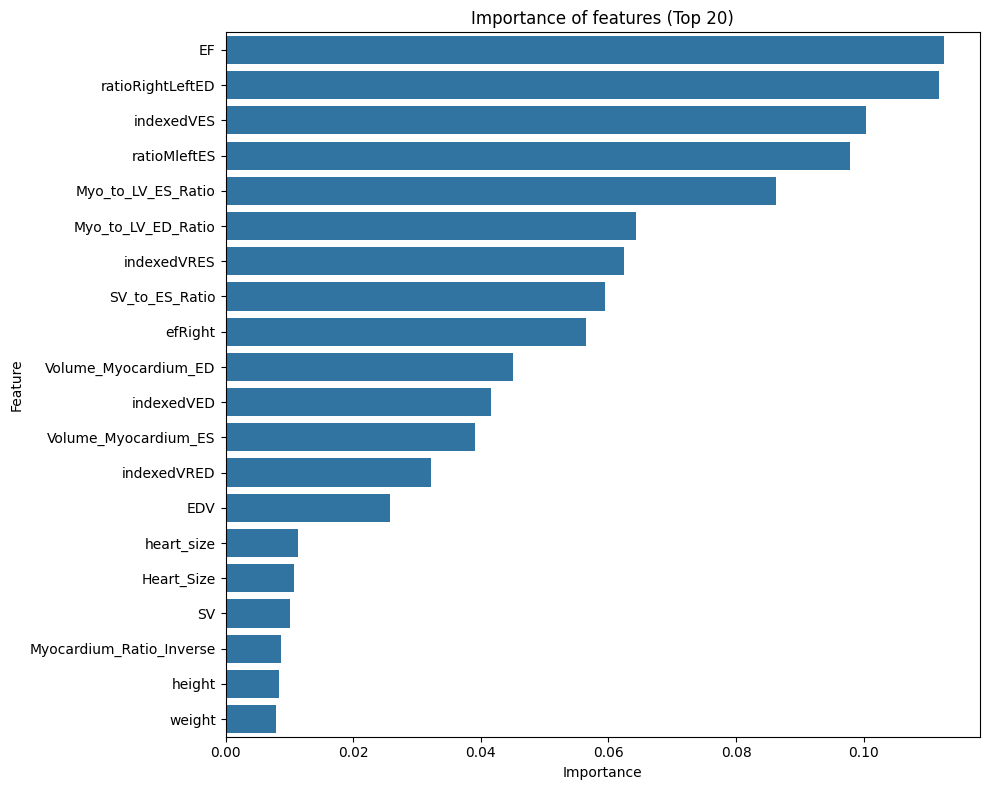

<Figure size 800x800 with 0 Axes>

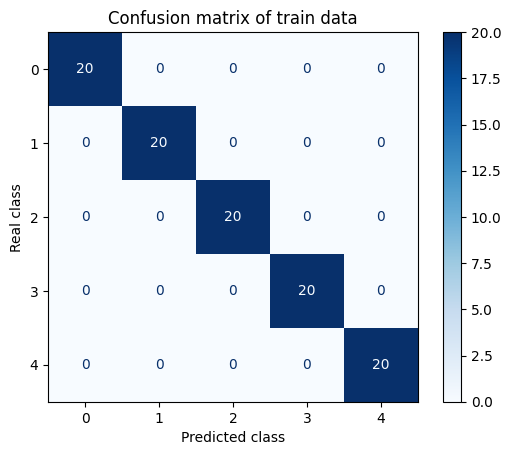

In [256]:
# Feature importance

importances = clf.feature_importances_ # Use importances from the optimized model

# Create a DataFrame to store feature names and their importances
feat_imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
# Sort features by importance in descending order
feat_imp_df = feat_imp_df.sort_values(by="Importance", ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8)) 
sns.barplot(x="Importance", y="Feature", data=feat_imp_df.head(20)) # Display top 20 features
plt.title("Importance of features (Top 20)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()


# Confusion matrix

# Predict on the training data to generate the confusion matrix
y_train_pred = clf.predict(X_train) 
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_) 

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion matrix of train data")
plt.xlabel("Predicted class")
plt.ylabel("Real class")
plt.show()

<h3>vi) Prediction on test data </h3>

Here, we use what our classifier learnt in order to predict labels on our test data and export it as a .CSV.

In [ ]:
X_test, ids_test, _ = build_X_from_folder(test_folder_path, meta_test_path,test=True)

metadata_test = pd.read_csv(meta_test_path).set_index('Id')
y_test_pred = clf.predict(X_test)

# Save Predictions by creating a DataFrame to store the patient IDs and their predicted categories
results_df = pd.DataFrame({
    "Id": ids_test, # Use patient IDs from the merged test DataFrame
    "predicted_group": y_test_pred # Add the predicted categories
})

# Ensure the predicted_group column is of type string
results_df["predicted_group"] = results_df["predicted_group"].astype(str)

# Define the output file path
output_csv_path = "predictions_by_patient.csv"
# Save the results DataFrame to a CSV file without the index
results_df.to_csv(output_csv_path, index=False)

<h2>VI. AdaBoost method </h2>

The method used previously gives a very satisfying result but I still wanted to try an AdaBoost to see how it would work out. In order to test this, the architecture is exactly the same as the one used in the previous technique, we simply have to replace the random forest by the AdaBoost.


C:\Users\Anissa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Anissa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Anissa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent

Scores de validation croisée AdaBoost : [0.7  0.65 0.7  0.5  0.65]
Moyenne des scores de validation croisée AdaBoost : 0.6399999999999999
Variance des scores de validation croisée AdaBoost : 0.005399999999999998


<Figure size 800x800 with 0 Axes>

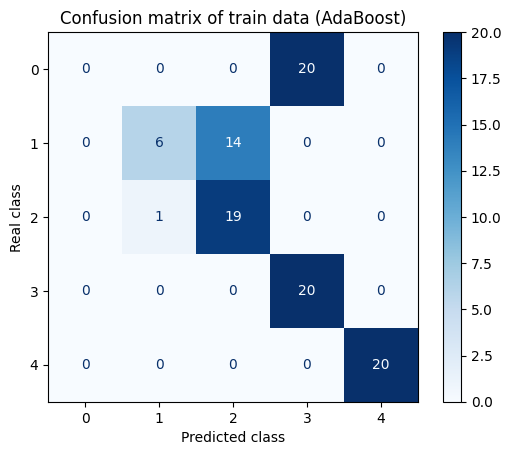

In [ ]:
# Initialize the AdaBoost Classifier 
adaboost_clf = AdaBoostClassifier(n_estimators=100, random_state=42)  # Use 100 weak learners 

# Train the Classifier
adaboost_clf.fit(X_train, y_train)

# Cross-Validation Scores (5-Fold) 
cv_scores_adaboost = cross_val_score(adaboost_clf, X_train, y_train, cv=5)  # Evaluate generalization performance
print(f"Cross-validation scores (AdaBoost): {cv_scores_adaboost}")
print(f"Mean cross-validation score (AdaBoost): {np.mean(cv_scores_adaboost)}")
print(f"Variance of cross-validation scores (AdaBoost): {np.var(cv_scores_adaboost)}")

y_train_pred_adaboost = adaboost_clf.predict(X_train)

# Compute Confusion Matrix 
cm_adaboost = confusion_matrix(y_train, y_train_pred_adaboost)
disp_adaboost_cm = ConfusionMatrixDisplay(confusion_matrix=cm_adaboost, display_labels=adaboost_clf.classes_)

# Predict Labels on Test Data 
y_test_pred_adaboost = adaboost_clf.predict(X_test)

plt.figure(figsize=(8, 8)) 
disp_adaboost_cm.plot(cmap='Blues', values_format='d')  
plt.title("Confusion Matrix of Train Data (AdaBoost)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


Unfortunately the result is not satisfying at all.